In [403]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### 1. Abrindo Imagem

60.bmp<br>
82.bmp<br>
114.bmp<br>
150.bmp<br>
205.bmp

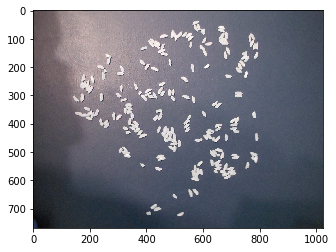

In [404]:
imagem = cv2.imread("205.bmp")
plt.imshow(imagem)

### 2. Convertendo para escala de cinza

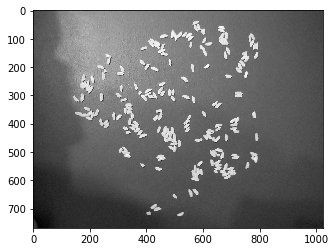

In [405]:
imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
plt.imshow(imagem_cinza, cmap='gray') #As cores ficam zoadas no Jupyter se deixar sem esse parâmetro

In [406]:
imagem = imagem_cinza

### Normalização local

Reduzir problemas de iluminação na imagem

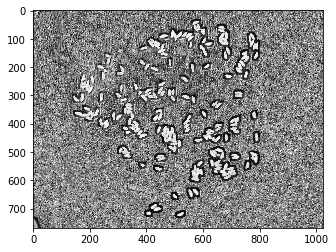

In [407]:
tamanho_janela = 13
kernel = np.ones((tamanho_janela, tamanho_janela),np.uint8)
minimo = cv2.erode(imagem, kernel)
maximo = cv2.dilate(imagem, kernel)

imagem_normalizada_local = (imagem - minimo) / (maximo - minimo)

plt.imshow(imagem_normalizada_local, cmap='gray')

In [408]:
imagem = np.uint8(imagem_normalizada_local * 255.0)

### Filtro da Mediana

Homogeneizar as texturas

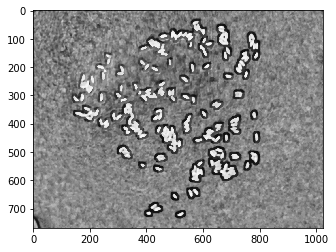

In [409]:
tamanho_janela = 7
imagem_borrada = cv2.medianBlur(imagem, tamanho_janela)
plt.imshow(imagem_borrada, cmap='gray')

In [410]:
imagem = imagem_borrada

### Limiarização global

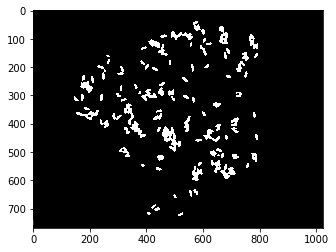

In [411]:
ret,imagem_limiarizacao_global = cv2.threshold(imagem, 200, 255, cv2.THRESH_BINARY)
plt.imshow(imagem_limiarizacao_global, cmap='gray')

In [412]:
imagem = imagem_limiarizacao_global

### Para salvar o arquivo localmente

In [413]:
cv2.imwrite("./debug.png", imagem)

True